In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from skimage import io
from skimage.transform import resize
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import ResNet50, DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.applications import InceptionV3
import matplotlib.pyplot as plt


# **NEXGEN**

In [63]:
# Load CSV data
train_data = pd.read_csv('softec24-final-round/Training.csv')

In [64]:
train_data.head()


,Image,Label
0,0_1000.png,Normal
1,3000_3500.png,Mitosis
2,6500_4000.png,Mitosis
3,7000_2500.png,Mitosis
4,2000_2500.png,Mitosis


In [65]:
# Load and preprocess images
label_encoder = LabelEncoder()
image_folder = 'softec24-final-round/Training Image/'
target_size = (128, 128)  # Adjust the size as per your requirements
#(4032, 3024)

In [66]:
# Convert the 'Image' column to strings
train_data['Image'] = train_data['Image'].astype(str)
train_data['Label'] = label_encoder.fit_transform(train_data['Label'])



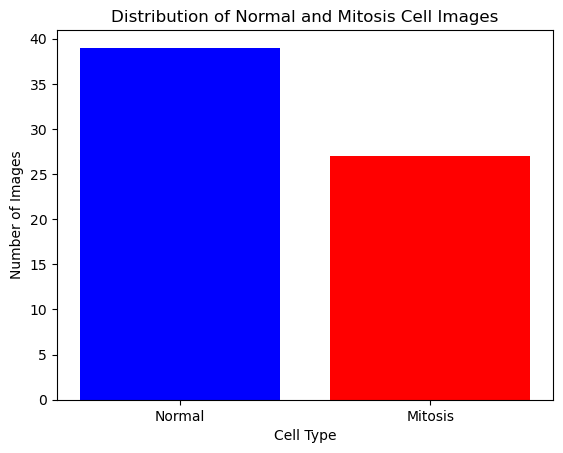

In [67]:
label_counts = train_data['Label'].value_counts()

# Plotting
plt.bar(label_counts.index, label_counts.values, color=['blue', 'red'])
plt.xlabel('Cell Type')
plt.ylabel('Number of Images')
plt.title('Distribution of Normal and Mitosis Cell Images')
plt.xticks(label_counts.index, ['Normal', 'Mitosis'])
plt.show()

In [68]:
train_data.head()

,Image,Label
0,0_1000.png,1
1,3000_3500.png,0
2,6500_4000.png,0
3,7000_2500.png,0
4,2000_2500.png,0


In [69]:
# Create a tf.data.Dataset for parallel loading
dataset = tf.data.Dataset.from_tensor_slices((
    tf.constant(train_data['Image'].values),
    tf.constant(train_data['Label'].values)
))

In [70]:
# Define a function to load and preprocess images
def load_and_preprocess_image(image_path, label):
    img_path = tf.strings.join([tf.constant(image_folder), image_path])
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)  # Use decode_png for PNG images

    # Calculate aspect ratio and resize while maintaining the aspect ratio
    aspect_ratio = tf.cast(tf.shape(img)[1] / tf.shape(img)[0], tf.float32)
    target_height = tf.cast(target_size[1], tf.float32)
    target_width = tf.cast(target_size[0], tf.float32)

    new_height = tf.cast(target_width / aspect_ratio, tf.int32)
    new_width = tf.cast(target_height * aspect_ratio, tf.int32)

    img = tf.image.resize(img, [new_height, new_width])

    # Pad the image to the target size if needed
    img = tf.image.resize_with_pad(img, target_size[0], target_size[1])

    img = tf.cast(img, tf.float32) / 255.0
    return img, label




In [71]:
# Use map and parallelize loading
dataset = dataset.map(
    lambda x, y: load_and_preprocess_image(x, y),
    num_parallel_calls=tf.data.AUTOTUNE
)

In [72]:
# # Data Augmentation using ImageDataGenerator
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='nearest'
# )

In [73]:
# def augment_data(img, label):
#     img = datagen.random_transform(img)
#     return img, label


In [75]:
# Batch and prefetch the dataset
batch_size = 32
dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Extract X (images) and y (labels) from the dataset
X, y = next(iter(dataset))

In [76]:
X_np=X.numpy()

In [77]:
X_np.shape

(32, 128, 128, 3)

In [78]:
indeces=np.array(y)

In [79]:

X_train, X_val, y_train, y_val = train_test_split(X_np, indeces, test_size=0.2)


In [80]:
print(type(X_train))
print((X_train))
print(type(X_val))
print((X_val))
print(type(y_train))
print((y_train))
print(type(y_val))
print((y_val))

<class 'numpy.ndarray'>
[[[[0.47549018 0.2382353  0.51666665]
   [0.40882352 0.16960785 0.45392156]
   [0.4        0.16078432 0.44509804]
   ...
   [0.85784316 0.622549   0.75784314]
   [0.8598039  0.6166667  0.7470588 ]
   [0.8882353  0.63039213 0.777451  ]]

  [[0.49411765 0.24607843 0.54901963]
   [0.4343137  0.23039216 0.49509802]
   [0.43039215 0.19803922 0.46666667]
   ...
   [0.9264706  0.65392154 0.8068628 ]
   [0.99019605 0.7137255  0.82941175]
   [0.99607843 0.70686275 0.8088235 ]]

  [[0.7254902  0.4372549  0.627451  ]
   [0.7088235  0.4127451  0.6392157 ]
   [0.73137254 0.42156863 0.6431373 ]
   ...
   [0.9284314  0.58137256 0.75      ]
   [0.904902   0.5637255  0.70686275]
   [0.8519608  0.51666665 0.66568625]]

  ...

  [[0.55196077 0.24117647 0.5137255 ]
   [0.5637255  0.25392157 0.5107843 ]
   [0.64705884 0.33137256 0.58431375]
   ...
   [0.93333334 0.6039216  0.7137255 ]
   [0.97745097 0.6156863  0.7794118 ]
   [0.88529414 0.51862746 0.69509804]]

  [[0.4882353  0.2176

In [81]:
# Use a pre-trained model (InceptionV3 in this case)
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(target_size[0], target_size[1], 3))
#Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False


# model

In [82]:
from tensorflow.keras.regularizers import l2
# Create a new model on top
# model = models.Sequential()
# model.add(base_model)
# model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(1, activation='sigmoid'))

# Build your classification model on top of DenseNet
# model = models.Sequential()
# model.add(base_model)
# model.add(layers.GlobalAveragePooling2D())
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(1, activation='sigmoid'))

# THIS IS usableBuild your classification model on top of EfficientNet
# model = models.Sequential()
# model.add(base_model)
# model.add(layers.GlobalAveragePooling2D())
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(1, activation='sigmoid'))

model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))# kernel_regularizer=l2(0.001)))  # L2 regularization with factor 0.001, 2)from 384
model.add(layers.Dropout(0.7))
model.add(layers.Dense(1, activation='sigmoid'))



In [83]:
# Compile the model with a learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


In [84]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [85]:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [86]:
# Fine-Tuning: Unfreeze the last few layers

# for layer in base_model.layers[-20:]:
#     layer.trainable = True


In [87]:
print(set(y_train))


{0, 1}


In [88]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 22065185 (84.17 MB)
Trainable params: 2197761 (8.38 MB)
Non-trainable params: 19867424 (75.79 MB)
________

In [89]:
#model.load_weights(weights_path2)
hist=model.fit(X_train, y_train, epochs=9, validation_data=(X_val, y_val))

Epoch 1/9
1/1 [==============================] - 31s 31s/step - loss: 1.8311 - accuracy: 0.4000 - val_loss: 0.9557 - val_accuracy: 0.5714
Epoch 2/9
1/1 [==============================] - 1s 749ms/step - loss: 1.1417 - accuracy: 0.6400 - val_loss: 1.0973 - val_accuracy: 0.5714
Epoch 3/9
1/1 [==============================] - 1s 774ms/step - loss: 1.0028 - accuracy: 0.6800 - val_loss: 1.2261 - val_accuracy: 0.5714
Epoch 4/9
1/1 [==============================] - 1s 652ms/step - loss: 1.3609 - accuracy: 0.6800 - val_loss: 1.2982 - val_accuracy: 0.5714
Epoch 5/9
1/1 [==============================] - 1s 735ms/step - loss: 1.4149 - accuracy: 0.6400 - val_loss: 0.7566 - val_accuracy: 0.5714
Epoch 6/9
1/1 [==============================] - 1s 715ms/step - loss: 0.5120 - accuracy: 0.7200 - val_loss: 0.6010 - val_accuracy: 0.7143
Epoch 7/9
1/1 [==============================] - 1s 700ms/step - loss: 0.8028 - accuracy: 0.7200 - val_loss: 0.5731 - val_accuracy: 0.8571
Epoch 8/9
1/1 [=============

In [ ]:
#model.save_weights("/content/drive/MyDrive/weights_7_epochs.h5")


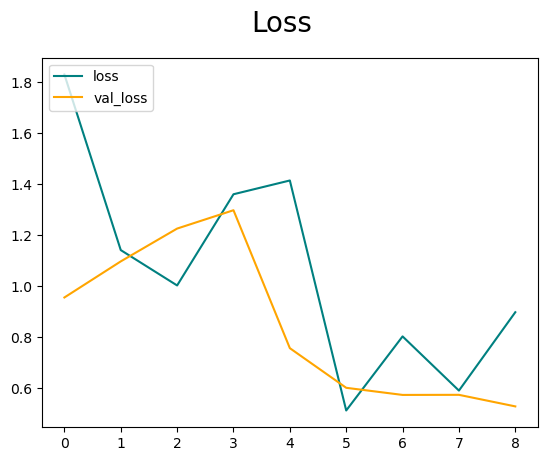

In [90]:
fig=plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc="upper left")
plt.show()

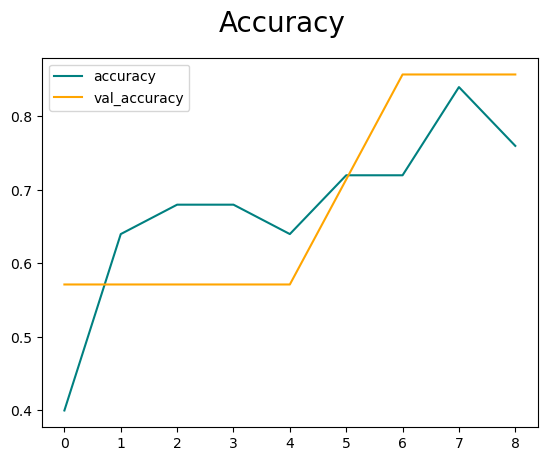

In [91]:
fig=plt.figure()
plt.plot(hist.history['accuracy'],color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'],color='orange',label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [92]:
import numpy as np
y_pred = model.predict(X_val)
pred_probs_array = np.array(y_pred)

mean = np.mean(pred_probs_array)
median = np.median(pred_probs_array)
std_dev = np.std(pred_probs_array)

pmax_val = np.max(pred_probs_array)
pmin_val = np.min(pred_probs_array)

above_median = np.sum(pred_probs_array > mean)
below_median = np.sum(pred_probs_array < mean)

q1 = np.percentile(pred_probs_array, 25)
q2 = np.percentile(pred_probs_array, 50)
q3 = np.percentile(pred_probs_array, 75)

below_q1 = np.sum(pred_probs_array < q1)
between_q1_q2 = np.sum((pred_probs_array >= q1) & (pred_probs_array < q2))
between_q2_q3 = np.sum((pred_probs_array >= q2) & (pred_probs_array < q3))
above_q3 = np.sum(pred_probs_array > q3)

print("len of pred data", len(pred_probs_array))
print("Mean:", mean)
print("Median:", median)
print("Standard Deviation:", std_dev)
print("pred min val:", pmin_val)
print("pred max val:", pmax_val)
print("Data above mean:", above_median)
print("Data below mean:", below_median)
print("Data below Q1:", below_q1)
print("Data between Q1 and Q2:", between_q1_q2)
print("Data between Q2 and Q3:", between_q2_q3)
print("Data above Q3:", above_q3)

print(y_pred)

1/1 [==============================] - 8s 8s/step
len of pred data 7
Mean: 0.25403407
Median: 0.13753715
Standard Deviation: 0.32624158
pred min val: 0.00030339512
pred max val: 0.9769916
Data above mean: 2
Data below mean: 5
Data below Q1: 2
Data between Q1 and Q2: 1
Data between Q2 and Q3: 2
Data above Q3: 2
[[9.7699159e-01]
 [1.5580121e-01]
 [4.4172668e-01]
 [3.0339512e-04]
 [3.1693773e-03]
 [1.3753715e-01]
 [6.2708966e-02]]


In [97]:
# Evaluate the model on the validation set

# y_pred_binary = (y_pred > (mean - (std_dev/10))).astype(int)
y_pred_binary = (y_pred > 0.5).astype(int)



In [98]:
print (y_pred_binary)
print (y_val)

[[1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
[1 0 0 0 0 0 1]


In [99]:
# Evaluate the model
accuracy = accuracy_score(y_val, y_pred_binary)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.86


In [ ]:
# Print classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_binary))

In [101]:
from keras.preprocessing import image

# Load the test dataset
test_data2 = pd.read_csv('softec24-final-round/Testing.csv')

# Define the target image dimensions
target_img_width, target_img_height = 128, 128

# Preprocess the test images
test_images2 = []
for img_name in test_data2['Image']:
    img_path = 'softec24-final-round/Testing Image/' + str(img_name)

    # Load and resize the image
    img = image.load_img(img_path, target_size=(target_img_width, target_img_height))
    img = image.img_to_array(img)
    img = img / 255.0  # Normalize pixel values
    test_images2.append(img)

test_images2 = np.array(test_images2)
model_input_shape = model.layers[0].input_shape
print(f"Model input shape: {model_input_shape}")
print(f"Shape of resized test images: {test_images2.shape}")

# Make predictions using the trained model
predictions2 = model.predict(test_images2)


Model input shape: (None, 128, 128, 3)
Shape of resized test images: (99, 128, 128, 3)
4/4 [==============================] - 2s 493ms/step


In [102]:
pred_prob2 = np.array(predictions2)

mean = np.mean(pred_prob2)
median = np.median(pred_prob2)
std_dev = np.std(pred_prob2)

pmax_val = np.max(pred_prob2)
pmin_val = np.min(pred_prob2)

above_median = np.sum(pred_prob2 > mean)
below_median = np.sum(pred_prob2 < mean)

q1 = np.percentile(pred_prob2, 25)
q2 = np.percentile(pred_prob2, 50)
q3 = np.percentile(pred_prob2, 75)

below_q1 = np.sum(pred_prob2 < q1)
between_q1_q2 = np.sum((pred_prob2 >= q1) & (pred_prob2 < q2))
between_q2_q3 = np.sum((pred_prob2 >= q2) & (pred_prob2 < q3))
above_q3 = np.sum(pred_prob2 > q3)

print("len of pred data", len(pred_prob2))
print("Mean:", mean)
print("Median:", median)
print("Standard Deviation:", std_dev)
print("pred min val:", pmin_val)
print("pred max val:", pmax_val)
print("Data above mean:", above_median)
print("Data below mean:", below_median)
print("Data below Q1:", below_q1)
print("Data between Q1 and Q2:", between_q1_q2)
print("Data between Q2 and Q3:", between_q2_q3)
print("Data above Q3:", above_q3)


len of pred data 99
Mean: 0.28813857
Median: 0.09168026
Standard Deviation: 0.3326921
pred min val: 6.8818595e-06
pred max val: 0.9918067
Data above mean: 40
Data below mean: 59
Data below Q1: 25
Data between Q1 and Q2: 24
Data between Q2 and Q3: 25
Data above Q3: 25


In [105]:
threshold = ((mean))+(std_dev/10)
print(threshold)
# Convert predictions2 to class labels (assuming binary classification)
predicted_labels2 = ["Normal" if pred > 0.5 else "Mitosis" for pred in predictions2]

# Add predicted labels to the test data CSV file
test_data2['label'] = predicted_labels2

# Save the updated test data CSV file
test_data2.to_csv('softec24-final-round/submissions11.csv', index=False)

0.32140777707099916
